Package Imports

In [170]:
import gym
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import trange

Hyperparameters and constants:

In [178]:
NUM_FEATURES = 4
NUM_ACTIONS = 2
MAX_EPISODES = 1500
AVG_EPS_TO_COMPLETION = 10

alpha = 0.01
gamma = 0.9

Setting up the environment

In [183]:
env = gym.make("CartPole-v0")

c:\Users\Caleb\anaconda3\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


Creating the agent

In [173]:
class Agent(torch.nn.Module):

    def __init__(self): # Initialize agent
        super(Agent, self).__init__()
        
        self.layer1 = torch.nn.Linear(NUM_FEATURES, 128) # Adding linear and activation layers
        self.activ1 = torch.nn.Dropout(p=0.6)
        self.layer2 = torch.nn.Linear(128, NUM_ACTIONS)

    def forward(self, x): # Forward step
        x = self.layer1(x)
        x = self.activ1(x)
        x = torch.nn.functional.relu(x)
        x = self.layer2(x)
        
        return torch.nn.functional.softmax(x, dim=1) # Softmax over outputs

Run one episode of CartPole

In [152]:
def run_episode(policy):

    transitions = [] # Store state, action, reward tuples to return 
    state = env.reset()[0] # Get initial state
    terminated, truncated = False, False # Check if episode is done
    log_probs = [] # Store probabilities of action taken

    while not terminated and not truncated: # Iterate until episode end

        out = policy(torch.tensor(state).unsqueeze(0)) # Use the agent to create a distribution over possible actions given the current state
        dist = torch.distributions.Categorical(out) # Wrap the output probabilities in a format usable by torch
        action = dist.sample() # Select an action based on the distribution over all output actions
        next_state, reward, terminated, truncated, _ = env.step(action.item()) # Take an action in the environment
        transitions.append((state, action, reward)) # Store the tuple in the transitions list
        log_probs.append(dist.log_prob(action)) # Store the probability outputs for parameter updating later
        state = next_state # Update the state to the next state
        
    return np.array(transitions), log_probs

Main functionality

In [186]:
def main():

    model = Agent()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    rewards = []

    bar = trange(MAX_EPISODES, desc="Reward: ", leave=True) # Progress bar

    for episode in bar:

        transitions, log_probs = run_episode(model)
        reward = np.sum(transitions[:,2]) # Total reward gained during the episode
        rewards.append(reward) # Store all rewards for plotting
        loss = [] # Store loss for parameter updates

        for t in range(transitions.shape[0]): # Calculate discounted returns
            G = 0
            for r in range(t, transitions.shape[0]):
                G += transitions[r][2] * (gamma ** (r - t)) # Steps far in the future are heavily discounted
            loss.append(-G * log_probs[t])
        
        optimizer.zero_grad() # Zero out the gradients of the optimizer
        loss = torch.cat(loss).sum() # Calculate total loss of the episode
        loss.backward() # Compute loss gradients
        optimizer.step() # Parameter updates

        if episode > AVG_EPS_TO_COMPLETION: # Check if the last AVG_EPS_TO_COMPLETION episodes succeed
            avg_rewards_last_eps = np.sum(rewards[-AVG_EPS_TO_COMPLETION:]) / AVG_EPS_TO_COMPLETION
            if avg_rewards_last_eps > env.spec.reward_threshold: # Terminate if successful
                torch.save(model.state_dict(), 'final_model.pt')
                return rewards

        bar.set_description("Reward: " + str(reward)) # Update progress bar description
    
    return []

In [190]:
rewards = main()

Reward:   0%|          | 0/1500 [00:00<?, ?it/s]C:\Users\Caleb\AppData\Local\Temp/ipykernel_10024/3202585557.py:15: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array(transitions), log_probs
C:\Users\Caleb\AppData\Local\Temp/ipykernel_10024/3202585557.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(transitions), log_probs
Reward: 200.

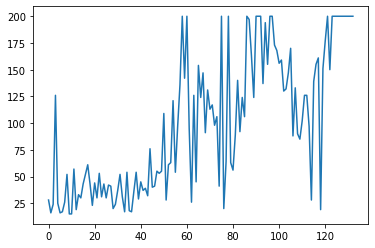

In [192]:
plt.plot(rewards)
plt.savefig("total_rewards.png")